In [34]:
# Keras and TF imports
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import optimizers
from keras import backend as K

In [13]:
# Scikit-learn and Numpy imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [14]:
from tensorflow import set_random_seed
set_random_seed(42)

## For lab PC

In [15]:
# set the location of the training and test images (change as required)
location_of_train_data = "D:\\Chess\\Chess ID Public Data\\output_train"
location_of_test_data = "D:\\Chess\\Chess ID Public Data\\output_test"
model_folder_name = "D:\\Chess\\models\\30_12"
tensorboard_logs_folder_location = "D:\\Chess\\tb_logs\\30_12"

## For laptop

In [19]:
location_of_train_data = "H:\\AR-ExtendingOnlineGames\\data\\chess_pieces_data\\Chess ID Public Data\\output_train"
location_of_test_data = "H:\\AR-ExtendingOnlineGames\data\\chess_pieces_data\\Chess ID Public Data\\output_test"
model_folder_name = "H:\\AR-ExtendingOnlineGames\\ExtendingGames_Code\\models\\30_12"
tensorboard_logs_folder_location = "H:\\AR-ExtendingOnlineGames\\tb_logs\\30_12"

In [20]:
class_names = ["white_bishop", "white_king", "white_knight", "white_pawn", "white_queen", "white_rook", "black_bishop", "black_king", "black_knight", "black_pawn", "black_queen", "black_rook", "empty"]
class_names_reverse_mappings = {"white_bishop": 0, "white_king": 1, "white_knight":2, "white_pawn":3, "white_queen":4, "white_rook":5, "black_bishop": 6, "black_king": 7, "black_knight": 8, "black_pawn": 9, "black_queen": 10, "black_rook": 11, "empty":12}
class_names_folder_mappings = {"white_bishop": ["wb"], "white_king": ["wk"], "white_knight":["wn"], "white_pawn":["wp"], "white_queen":["wq"], "white_rook":["wr"], "black_bishop": ["bb"], "black_king": ["bk"], "black_knight":["bn"], "black_pawn":["bp"], "black_queen":["bq"], "black_rook":["br"], "empty":["empty"]}

In [27]:
import cv2

def get_required_data_with_labels_for_model(base_location, num_samples = None, dimensions=(300, 300)):
  X, y = [], []
  for class_name in class_names_folder_mappings:
    for folder_name in class_names_folder_mappings[class_name]:
      complete_path = os.path.join(base_location, folder_name)
      print("Reading the files from the location {0}".format(complete_path))
      current_samples = 0
      for image_file_name in os.listdir(complete_path):
        
        # check if the current file is an image file with jpg extension
        if image_file_name.endswith(".jpg"):
          current_samples += 1
          img_path = os.path.join(complete_path, image_file_name)
            
          img = cv2.imread(img_path)  
          resized_img = cv2.resize(img,dimensions, interpolation = cv2.INTER_AREA) 
          
          x = resized_img
          X.append(x)
          class_name_id = class_names_reverse_mappings[class_name]
          y.append(class_name_id)
        
          if ((num_samples is not None) and (current_samples == num_samples)):
            break
  
  if len(X) > 0:
      X = np.array(X)
      X = X.astype('float32')
      X /= 255
  
  return X, y    
  

In [28]:
X_train, y_train = get_required_data_with_labels_for_model(location_of_train_data, 20)
print(len(X_train))
print(len(y_train))
print(X_train.shape)
print(X_train[0].shape)
print(y_train[0])

Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\wb
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\wk
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\wn
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\wp
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\wq
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\wr
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\bb
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_train\bk
Reading the file

In [29]:
X_test, y_test = get_required_data_with_labels_for_model(location_of_test_data, 10)
print(len(X_test))
print(len(y_test))
print(X_test[0].shape)
print(y_test[0])

Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\wb
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\wk
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\wn
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\wp
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\wq
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\wr
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\bb
Reading the files from the location H:\AR-ExtendingOnlineGames\data\chess_pieces_data\Chess ID Public Data\output_test\bk
Reading the files from t

### Configurations to be updated as required

In [30]:
batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# number of training epochs
nb_epoch = 150

In [35]:
# convolution kernel size
nb_conv = 3

# shape of each image
shape_ord = (300, 300, 3)

# number of output classes
nb_classes = 13

def train_custom_cnn_model(X_train, Y_train, X_test, Y_test):
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                     padding='valid',
                     input_shape=shape_ord))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    
    model.add(Conv2D(nb_filters * 2, (nb_conv, nb_conv)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    
    model.add(Conv2D(nb_filters * 4, (nb_conv, nb_conv)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.summary()

    # checkpoint
    if not os.path.exists(model_folder_name):
        os.makedirs(model_folder_name)
    
    filepath = os.path.join(model_folder_name, "custom_cnn.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                                 save_best_only=True,
                                 mode='max')

    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10,
                              verbose=1, mode='max')
    
    tensorboard = TensorBoard(log_dir=tensorboard_logs_folder_location, histogram_freq=0, write_graph=True, write_images=True)
    
    callbacks_list = [checkpoint, earlystop, tensorboard]
    
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    hist = model.fit(X_train, Y_train, shuffle=True, batch_size=batch_size,
                     epochs=nb_epoch, verbose=1,
                     validation_data=(X_test, Y_test), callbacks=callbacks_list)

    # Evaluating the model on the test data
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    return hist, model

In [36]:
hist, model = train_custom_cnn_model(X_train, y_train, X_test, y_test)

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 298, 298, 32)      128       
_________________________________________________________________
activation_11 (Activation)   (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 147, 147, 64)      256       
_________________________________________________________________
activation_12 (Activation)   (None, 147, 147, 64)      0         
__________

NameError: name 'nb_epoch' is not defined

In [0]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Score: [1.9920576974457385, 0.637254902252964]
Normalized confusion matrix
[[0.57142857 0.         0.         0.28571429 0.14285714 0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.4        0.         0.         0.6        0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.9        0.1        0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.22222222 0.         0.         0.11111111 0.11111111 0.55555556
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.375      0.         0.625      0.         0.        ]
 [0.         0

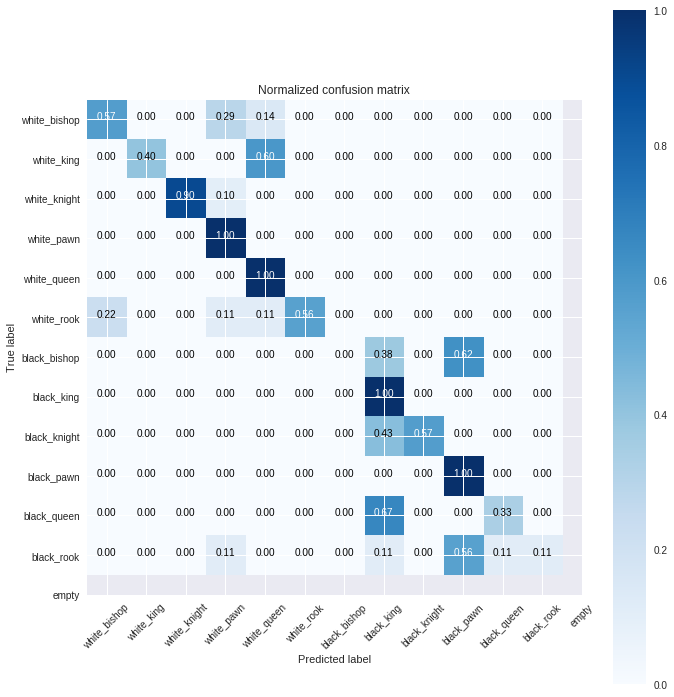

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

test_predictions = model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')